# ***Replica Clinical State Binary Classification***

This notebook shows the process of classification section samples into binary clinical state (high grade, low grade).

### ***Import packages***

Before we begin, let's import all the necessary packages for this notebook:

In [1]:
import gc
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from typing import Tuple
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from sklearn import metrics
from sklearn.model_selection import train_test_split
from skimage import (filters)
from tqdm import tqdm
from pyimzml.ImzMLParser import ImzMLParser, getionimage

### ***Constants definitions***

Next, let's define some constant variables for this notebook:

In [2]:
# Define folder that contains the dataset and files
DHG_PATH = "C:/Users/Leor/Desktop/Thesis/DHG"
# Define folder that contains the preprocessed dataset
DATA_IN_PATH = f"{DHG_PATH}/Preprocessed"
# Define file that contains clinical state annotations
CLINICAL_STATE_ANNOTATIONS_PATH = f"{DHG_PATH}/Clinical_state_annotations.csv"
# Define folder to save classification models for later use
MODELS_PATH = "C:/Users/Leor/Desktop/Thesis/section_classification_models"
# Classification model number of epochs
EPHOCS = 100
# Classification model batch size
BATCH_SIZE = 256
# Classification model learning rate
LEARNING_RATE = 1e-3
# MSI Spectra dimension
SPECTRA_DIM = 92000
# The MSI sample type for filtering
SAMPLE_TYPE = "r"
# Mz value to get in order to threshold for tissue
TRESH_MZ = 750
# Mz tolerance value to get in order to threshold for tissue
TRESH_MZ_TOL = 150
# Treshould standard deviation for Gaussian kernel
TRESH_GAUSSIAN_SIGMA = 0.5

### ***Reading MSI clinical state anotations***

Next, let's read the clinical state anotations for each MSI:

In [3]:
# Read clinical state annotations csv
clinical_state_df = pd.read_csv(CLINICAL_STATE_ANNOTATIONS_PATH)

# Filter by sample_type
clinical_state_df = clinical_state_df[clinical_state_df["sample_type"] ==
                                      SAMPLE_TYPE]

### ***Get all spectra's from all MSI:***

Next, let's get all information except intensities (which needs a lot of memory) for each spectra from all MSI:

In [4]:
# Create lists to store each spectra's info
file_names = []
sample_numbers = []
histologies = []
who_grades = []
x_coordinates = []
y_coordinates = []
idxs = []
is_tissue = []

# Loop over each MSI
for index, msi_row in tqdm(clinical_state_df.iterrows(),
                           total=clinical_state_df.shape[0],
                           desc="MSI Loop"):
  # Parse the MSI file
  with ImzMLParser(os.path.join(DATA_IN_PATH,
                                f"{msi_row.file_name}.imzML")) as reader:
    # Get local TIC image of msi in mz region [600, 900]
    local_tic_img = getionimage(reader, TRESH_MZ, tol=TRESH_MZ_TOL)

    # Threshold image to separate tissue spectra from background
    smooth = filters.gaussian(local_tic_img, sigma=TRESH_GAUSSIAN_SIGMA)
    thresh_mean = filters.threshold_mean(smooth)
    thresh_img = local_tic_img > thresh_mean

    # Loop over each spectra
    for idx, (x, y, z) in tqdm(enumerate(reader.coordinates),
                               total=len(reader.coordinates),
                               desc="Spectra Loop"):
      # Keep sample file name of spectra
      file_names.append(msi_row.file_name)
      # Keep sample number of spectra
      sample_numbers.append(msi_row.sample_number)
      # Keep sample histology of spectra
      histologies.append(msi_row.histology)
      # Keep sample who grade of spectra
      who_grades.append(msi_row.who_grade)
      # Keep x coordinate of spectra
      x_coordinates.append(x)
      # Keep y coordinate of spectra
      y_coordinates.append(y)
      # Keep  of spectra
      idxs.append(idx)
      # Check if spectra is tissue
      if thresh_img[y - 1, x - 1]:
        # Keep boolean indication on if spectra is tissue
        is_tissue.append(True)
      else:
        # Keep boolean indication on if spectra is not tissue
        is_tissue.append(False)
        
# Convert to numpy array
file_names = np.array(file_names)
sample_numbers = np.array(sample_numbers)
histologies = np.array(histologies)
who_grades = np.array(who_grades)
x_coordinates = np.array(x_coordinates)
y_coordinates = np.array(y_coordinates)
idxs = np.array(idxs)
is_tissue = np.array(is_tissue)
labels = (who_grades > 2).astype(int)

MSI Loop: 100%|██████████| 24/24 [02:57<00:00,  7.39s/it]


### ***MSI parsers opening:***

Next, let's create parser for each MSI in order to read spectra's for the model:

In [5]:
# Opening parsers
parsers = {
    file_name: ImzMLParser(os.path.join(DATA_IN_PATH, f"{file_name}.imzML"))
    for file_name in clinical_state_df.file_name.unique()
}

### ***Dataset generator:***

Next, let's create a dataset generator for the model:

In [6]:
def map_index(index: tf.Tensor) -> Tuple[np.ndarray, int]:
  """Function to map index to model input (spectra) and output (label).

  Args:
      index (tf.Tensor): index to map to corresponding values.

  Returns:
      Tuple[np.ndarray, int]: input (spectra) and output (label).
  
  """
  # Decoding index from the EagerTensor object
  index = index.numpy()
  # Reading spectra from parser
  file_name = file_names[index]
  idx = idxs[index]
  _, spectra = parsers[file_name].getspectrum(idx)
  # Return spectra and label
  return (spectra, labels[index])


def _fixup_shape(x: tf.Tensor, y: tf.Tensor):
  """ Function to Fix the implicit inferring of the shapes of the
  output Tensors.

  Args:
      x (tf.Tensor): input (spectra)
      y (tf.Tensor): output (label)

  Returns:
      Tuple[np.ndarray, np.ndarray]: input (spectra) and output (label) with
        correct shape.
  
  """
  x.set_shape([SPECTRA_DIM])
  y.set_shape([])
  return x, y


def create_ds(indexes: np.ndarray, batch_size: int) -> tf.data.Dataset:
  """Function to create a dataset for model

  Args:
      indexes (np.ndarray): indexes of thh dataset
      batch_size (int): batch size

  Returns:
      tf.data.Dataset: dataset
  """
  # Create dataset from indexes
  ds = tf.data.Dataset.from_tensor_slices(indexes)
  # Shuffle the data
  ds = ds.shuffle(len(indexes))
  # Map index to spectra
  ds = ds.map(lambda i: tf.py_function(
      func=map_index, inp=[i], Tout=[tf.float32, tf.float32]))
  # Fix the implicit inferring of the shapes of the
  # output Tensors
  ds = ds.map(_fixup_shape)
  # Batch the spectra's
  ds = ds.batch(batch_size)
  # Prefetch batchs to make sure that a batch is ready to
  # be served at all time
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

### ***Classification model:***

Next, let's create a classification dense neural network model:

In [7]:
def get_model() -> tf.keras.Model:
  """Function to generate classification model.

  Returns:
      tf.keras.Model: classification model.
  
  """
  return tf.keras.Sequential(
    [
      layers.InputLayer(input_shape=(SPECTRA_DIM,)),
      layers.Dropout(0.5),
      layers.Dense(1024),
      layers.ReLU(),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(1024),
      layers.ReLU(),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(512),
      layers.ReLU(),
      layers.BatchNormalization(),
      layers.Dropout(0.5),
      layers.Dense(1, activation='sigmoid')
    ]
  )

### ***Leave one sample out classification:***

Next, let"s create a classification model for each leave one sample out option:

In [8]:
train_metrics = {}
validation_metrics = {}

# Loop over each sample number
for exclude_sample in tqdm(np.unique(sample_numbers)):
  # Clear graph
  K.clear_session()
  gc.collect()

  # Create filter for training data - does not include the excluded sample
  # and only include tissue spectra's
  train_filter = ((sample_numbers != exclude_sample) & is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Get indexes of training data
  train_indexes = indexes[train_filter]

  # Get indexes of training and validation data
  train_indexes, val_indexes = train_test_split(train_indexes,
                                                test_size=0.2,
                                                random_state=0,
                                                stratify=labels[train_filter])

  # Create data generators
  train_generator = create_ds(train_indexes, BATCH_SIZE)
  validation_generator = create_ds(val_indexes, BATCH_SIZE)

  # Create Callback to save the best model
  checkpoint_filepath = os.path.join(MODELS_PATH, f"excluded_{exclude_sample}/")
  model_checkpoint_callback = callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=False,
      monitor="val_binary_accuracy",
      mode="max",
      save_best_only=True)

  # Create Callback for model early stopping
  model_es_callback = callbacks.EarlyStopping(monitor='val_loss',
                                              mode='min',
                                              verbose=1,
                                              patience=5,
                                              min_delta=0.0001)

  # Create classification model
  classification_model = get_model()

  # Compile the classification model
  optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
  classification_model.compile(optimizer,
                               loss=losses.BinaryCrossentropy(),
                               metrics=["binary_accuracy"])

  # Train the classification model
  history = classification_model.fit(
      x=train_generator,
      validation_data=validation_generator,
      epochs=EPHOCS,
      callbacks=[model_checkpoint_callback, model_es_callback])

  # Load the best saved
  classification_model = tf.keras.models.load_model(checkpoint_filepath)

  # Evalute on train and validation
  train_metrics[exclude_sample] = classification_model.evaluate(
      x=train_generator)
  validation_metrics[exclude_sample] = classification_model.evaluate(
      x=validation_generator)

  # Clean model for next iteration
  classification_model = None

  # Separate training 
  print("#" * 30)

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1/100
126/126 [==============================] - 43s 334ms/step - loss: 0.0662 - binary_accuracy: 0.9748 - val_loss: 0.6581 - val_binary_accuracy: 0.6165
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_2\assets
Epoch 2/100
126/126 [==============================] - 40s 315ms/step - loss: 0.0143 - binary_accuracy: 0.9970 - val_loss: 0.5739 - val_binary_accuracy: 0.9969
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_2\assets
Epoch 3/100
126/126 [==============================] - 40s 322ms/step - loss: 0.0048 - binary_accuracy: 0.9984 - val_loss: 0.3529 - val_binary_accuracy: 0.9919
Epoch 4/100
126/126 [==============================] - 35s 280ms/step - loss: 0.0046 - binary_accuracy: 0.9987 - val_loss: 0.3232 - val_binary_accuracy: 0.8497
Epoch 5/100
126/126 [==============================] - 32s 252ms/step - loss: 0.0029 - binary_accuracy: 0.9992 - val_loss: 0.0108 - val_

  5%|▍         | 1/22 [07:02<2:28:00, 422.86s/it]

##############################
Epoch 1/100
125/125 [==============================] - 32s 252ms/step - loss: 0.0815 - binary_accuracy: 0.9662 - val_loss: 0.6740 - val_binary_accuracy: 0.5457
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_3\assets
Epoch 2/100
125/125 [==============================] - 30s 238ms/step - loss: 0.0081 - binary_accuracy: 0.9981 - val_loss: 0.6221 - val_binary_accuracy: 0.7299
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_3\assets
Epoch 3/100
125/125 [==============================] - 32s 252ms/step - loss: 0.0056 - binary_accuracy: 0.9984 - val_loss: 0.4047 - val_binary_accuracy: 0.9888
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_3\assets
Epoch 4/100
125/125 [==============================] - 32s 255ms/step - loss: 0.0033 - binary_accuracy: 0.9990 - val_loss: 0.1638 - val_binary_accuracy: 

  9%|▉         | 2/22 [15:46<2:40:44, 482.23s/it]

##############################
Epoch 1/100
132/132 [==============================] - 35s 260ms/step - loss: 0.0767 - binary_accuracy: 0.9677 - val_loss: 0.6692 - val_binary_accuracy: 0.5710
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_4\assets
Epoch 2/100
132/132 [==============================] - 33s 250ms/step - loss: 0.0081 - binary_accuracy: 0.9973 - val_loss: 0.6823 - val_binary_accuracy: 0.4293
Epoch 3/100
132/132 [==============================] - 33s 250ms/step - loss: 0.0063 - binary_accuracy: 0.9982 - val_loss: 0.8405 - val_binary_accuracy: 0.4318
Epoch 4/100
132/132 [==============================] - 33s 252ms/step - loss: 0.0050 - binary_accuracy: 0.9987 - val_loss: 0.2895 - val_binary_accuracy: 0.8476
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_4\assets
Epoch 5/100
132/132 [==============================] - 32s 240ms/step - loss: 0.0022 - binary_accuracy: 0

 14%|█▎        | 3/22 [25:11<2:44:37, 519.88s/it]

##############################
Epoch 1/100
131/131 [==============================] - 35s 265ms/step - loss: 0.0866 - binary_accuracy: 0.9665 - val_loss: 0.6676 - val_binary_accuracy: 0.5664
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_5\assets
Epoch 2/100
131/131 [==============================] - 34s 256ms/step - loss: 0.0083 - binary_accuracy: 0.9975 - val_loss: 0.7127 - val_binary_accuracy: 0.4336
Epoch 3/100
131/131 [==============================] - 33s 255ms/step - loss: 0.0062 - binary_accuracy: 0.9983 - val_loss: 0.3937 - val_binary_accuracy: 0.9495
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_5\assets
Epoch 4/100
131/131 [==============================] - 35s 266ms/step - loss: 0.0035 - binary_accuracy: 0.9990 - val_loss: 0.0711 - val_binary_accuracy: 0.9993
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_5\

 18%|█▊        | 4/22 [31:40<2:20:26, 468.16s/it]

##############################
Epoch 1/100
130/130 [==============================] - 36s 273ms/step - loss: 0.0743 - binary_accuracy: 0.9697 - val_loss: 0.6951 - val_binary_accuracy: 0.4354
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_6\assets
Epoch 2/100
130/130 [==============================] - 33s 257ms/step - loss: 0.0082 - binary_accuracy: 0.9981 - val_loss: 0.7974 - val_binary_accuracy: 0.4354
Epoch 3/100
130/130 [==============================] - 34s 260ms/step - loss: 0.0044 - binary_accuracy: 0.9986 - val_loss: 0.8241 - val_binary_accuracy: 0.4371
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_6\assets
Epoch 4/100
130/130 [==============================] - 34s 258ms/step - loss: 0.0033 - binary_accuracy: 0.9991 - val_loss: 0.3328 - val_binary_accuracy: 0.8107
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_6\

 23%|██▎       | 5/22 [38:05<2:04:09, 438.19s/it]

##############################
Epoch 1/100
131/131 [==============================] - 35s 266ms/step - loss: 0.0764 - binary_accuracy: 0.9707 - val_loss: 0.6682 - val_binary_accuracy: 0.5665
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_7\assets
Epoch 2/100
131/131 [==============================] - 39s 296ms/step - loss: 0.0074 - binary_accuracy: 0.9978 - val_loss: 0.5981 - val_binary_accuracy: 0.8626
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_7\assets
Epoch 3/100
131/131 [==============================] - 38s 289ms/step - loss: 0.0055 - binary_accuracy: 0.9984 - val_loss: 0.3957 - val_binary_accuracy: 0.8612
Epoch 4/100
131/131 [==============================] - 33s 256ms/step - loss: 0.0025 - binary_accuracy: 0.9992 - val_loss: 0.0601 - val_binary_accuracy: 0.9990
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_7\

 27%|██▋       | 6/22 [46:19<2:01:55, 457.22s/it]

##############################
Epoch 1/100
126/126 [==============================] - 34s 265ms/step - loss: 0.0808 - binary_accuracy: 0.9676 - val_loss: 0.6861 - val_binary_accuracy: 0.5484
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_8\assets
Epoch 2/100
126/126 [==============================] - 36s 282ms/step - loss: 0.0049 - binary_accuracy: 0.9986 - val_loss: 0.6030 - val_binary_accuracy: 0.5810
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_8\assets
Epoch 3/100
126/126 [==============================] - 35s 281ms/step - loss: 0.0048 - binary_accuracy: 0.9986 - val_loss: 0.4054 - val_binary_accuracy: 0.9146
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_8\assets
Epoch 4/100
126/126 [==============================] - 34s 265ms/step - loss: 0.0027 - binary_accuracy: 0.9990 - val_loss: 0.2674 - val_binary_accuracy: 

 32%|███▏      | 7/22 [53:52<1:53:58, 455.89s/it]

##############################
Epoch 1/100
130/130 [==============================] - 36s 267ms/step - loss: 0.0739 - binary_accuracy: 0.9689 - val_loss: 0.6844 - val_binary_accuracy: 0.5625
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_9\assets
Epoch 2/100
130/130 [==============================] - 32s 250ms/step - loss: 0.0074 - binary_accuracy: 0.9979 - val_loss: 0.5883 - val_binary_accuracy: 0.8583
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_9\assets
Epoch 3/100
130/130 [==============================] - 34s 260ms/step - loss: 0.0048 - binary_accuracy: 0.9985 - val_loss: 0.3518 - val_binary_accuracy: 0.9964
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_9\assets
Epoch 4/100
130/130 [==============================] - 33s 256ms/step - loss: 0.0047 - binary_accuracy: 0.9987 - val_loss: 0.1610 - val_binary_accuracy: 

 36%|███▋      | 8/22 [1:01:18<1:45:38, 452.72s/it]

##############################
Epoch 1/100
128/128 [==============================] - 35s 266ms/step - loss: 0.0851 - binary_accuracy: 0.9650 - val_loss: 0.6721 - val_binary_accuracy: 0.5555
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_10\assets
Epoch 2/100
128/128 [==============================] - 34s 262ms/step - loss: 0.0073 - binary_accuracy: 0.9979 - val_loss: 0.6973 - val_binary_accuracy: 0.4445
Epoch 3/100
128/128 [==============================] - 33s 258ms/step - loss: 0.0072 - binary_accuracy: 0.9987 - val_loss: 0.7237 - val_binary_accuracy: 0.4507
Epoch 4/100
128/128 [==============================] - 34s 263ms/step - loss: 0.0034 - binary_accuracy: 0.9988 - val_loss: 0.1284 - val_binary_accuracy: 0.9939
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_10\assets
Epoch 5/100
128/128 [==============================] - 30s 238ms/step - loss: 0.0034 - binary_accuracy:

 41%|████      | 9/22 [1:08:04<1:34:54, 438.07s/it]

##############################
Epoch 1/100
132/132 [==============================] - 35s 262ms/step - loss: 0.0749 - binary_accuracy: 0.9690 - val_loss: 0.6708 - val_binary_accuracy: 0.5690
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_11\assets
Epoch 2/100
132/132 [==============================] - 34s 261ms/step - loss: 0.0082 - binary_accuracy: 0.9976 - val_loss: 0.6185 - val_binary_accuracy: 0.8854
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_11\assets
Epoch 3/100
132/132 [==============================] - 35s 265ms/step - loss: 0.0069 - binary_accuracy: 0.9982 - val_loss: 0.4471 - val_binary_accuracy: 0.8148
Epoch 4/100
132/132 [==============================] - 34s 261ms/step - loss: 0.0027 - binary_accuracy: 0.9991 - val_loss: 0.0859 - val_binary_accuracy: 0.9918
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_

 45%|████▌     | 10/22 [1:15:17<1:27:19, 436.63s/it]

##############################
Epoch 1/100
131/131 [==============================] - 35s 257ms/step - loss: 0.0763 - binary_accuracy: 0.9695 - val_loss: 0.6684 - val_binary_accuracy: 0.5658
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_12\assets
Epoch 2/100
131/131 [==============================] - 33s 252ms/step - loss: 0.0080 - binary_accuracy: 0.9979 - val_loss: 0.6123 - val_binary_accuracy: 0.8386
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_12\assets
Epoch 3/100
131/131 [==============================] - 33s 254ms/step - loss: 0.0046 - binary_accuracy: 0.9989 - val_loss: 0.4991 - val_binary_accuracy: 0.7456
Epoch 4/100
131/131 [==============================] - 34s 256ms/step - loss: 0.0063 - binary_accuracy: 0.9984 - val_loss: 0.3224 - val_binary_accuracy: 0.8477
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_

 50%|█████     | 11/22 [1:22:22<1:19:21, 432.89s/it]

##############################
Epoch 1/100
126/126 [==============================] - 34s 263ms/step - loss: 0.0908 - binary_accuracy: 0.9646 - val_loss: 0.6919 - val_binary_accuracy: 0.5474
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_13\assets
Epoch 2/100
126/126 [==============================] - 32s 251ms/step - loss: 0.0067 - binary_accuracy: 0.9976 - val_loss: 0.6541 - val_binary_accuracy: 0.5474
Epoch 3/100
126/126 [==============================] - 32s 255ms/step - loss: 0.0028 - binary_accuracy: 0.9992 - val_loss: 0.4442 - val_binary_accuracy: 0.7987
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_13\assets
Epoch 4/100
126/126 [==============================] - 33s 262ms/step - loss: 0.0048 - binary_accuracy: 0.9983 - val_loss: 0.0804 - val_binary_accuracy: 0.9995
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_

 55%|█████▍    | 12/22 [1:31:55<1:19:16, 475.61s/it]

##############################
Epoch 1/100
127/127 [==============================] - 35s 272ms/step - loss: 0.0771 - binary_accuracy: 0.9692 - val_loss: 0.6889 - val_binary_accuracy: 0.5521
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_14\assets
Epoch 2/100
127/127 [==============================] - 34s 265ms/step - loss: 0.0067 - binary_accuracy: 0.9980 - val_loss: 0.6074 - val_binary_accuracy: 0.8600
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_14\assets
Epoch 3/100
127/127 [==============================] - 35s 271ms/step - loss: 0.0064 - binary_accuracy: 0.9986 - val_loss: 0.4197 - val_binary_accuracy: 0.9164
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_14\assets
Epoch 4/100
127/127 [==============================] - 33s 256ms/step - loss: 0.0030 - binary_accuracy: 0.9992 - val_loss: 0.1258 - val_binary_accurac

 59%|█████▉    | 13/22 [1:40:15<1:12:28, 483.11s/it]

##############################
Epoch 1/100
130/130 [==============================] - 32s 242ms/step - loss: 0.0848 - binary_accuracy: 0.9677 - val_loss: 0.7676 - val_binary_accuracy: 0.4356
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_15\assets
Epoch 2/100
130/130 [==============================] - 31s 237ms/step - loss: 0.0056 - binary_accuracy: 0.9983 - val_loss: 0.9993 - val_binary_accuracy: 0.4356
Epoch 3/100
130/130 [==============================] - 34s 263ms/step - loss: 0.0055 - binary_accuracy: 0.9986 - val_loss: 0.5442 - val_binary_accuracy: 0.5367
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_15\assets
Epoch 4/100
130/130 [==============================] - 35s 268ms/step - loss: 0.0039 - binary_accuracy: 0.9989 - val_loss: 0.4478 - val_binary_accuracy: 0.7380
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_

 64%|██████▎   | 14/22 [1:47:20<1:02:03, 465.43s/it]

##############################
Epoch 1/100
130/130 [==============================] - 34s 259ms/step - loss: 0.0743 - binary_accuracy: 0.9704 - val_loss: 0.7139 - val_binary_accuracy: 0.5990
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_16\assets
Epoch 2/100
130/130 [==============================] - 32s 249ms/step - loss: 0.0072 - binary_accuracy: 0.9985 - val_loss: 0.6210 - val_binary_accuracy: 0.6000
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_16\assets
Epoch 3/100
130/130 [==============================] - 33s 258ms/step - loss: 0.0050 - binary_accuracy: 0.9991 - val_loss: 0.3826 - val_binary_accuracy: 0.9648
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_16\assets
Epoch 4/100
130/130 [==============================] - 35s 273ms/step - loss: 0.0029 - binary_accuracy: 0.9991 - val_loss: 0.0522 - val_binary_accurac

 68%|██████▊   | 15/22 [1:53:49<51:36, 442.42s/it]  

##############################
Epoch 1/100
120/120 [==============================] - 32s 266ms/step - loss: 0.0937 - binary_accuracy: 0.9635 - val_loss: 0.6435 - val_binary_accuracy: 0.6473
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_18\assets
Epoch 2/100
120/120 [==============================] - 33s 273ms/step - loss: 0.0080 - binary_accuracy: 0.9977 - val_loss: 0.5856 - val_binary_accuracy: 0.6473
Epoch 3/100
120/120 [==============================] - 32s 264ms/step - loss: 0.0079 - binary_accuracy: 0.9986 - val_loss: 0.3875 - val_binary_accuracy: 0.9913
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_18\assets
Epoch 4/100
120/120 [==============================] - 31s 257ms/step - loss: 0.0048 - binary_accuracy: 0.9986 - val_loss: 0.1101 - val_binary_accuracy: 0.9987
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_

 73%|███████▎  | 16/22 [2:02:57<47:25, 474.26s/it]

##############################
Epoch 1/100
130/130 [==============================] - 32s 240ms/step - loss: 0.0821 - binary_accuracy: 0.9672 - val_loss: 0.6649 - val_binary_accuracy: 0.5964
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_19\assets
Epoch 2/100
130/130 [==============================] - 33s 253ms/step - loss: 0.0080 - binary_accuracy: 0.9978 - val_loss: 0.7108 - val_binary_accuracy: 0.4040
Epoch 3/100
130/130 [==============================] - 33s 256ms/step - loss: 0.0054 - binary_accuracy: 0.9985 - val_loss: 0.8340 - val_binary_accuracy: 0.4042
Epoch 4/100
130/130 [==============================] - 34s 260ms/step - loss: 0.0035 - binary_accuracy: 0.9991 - val_loss: 0.2316 - val_binary_accuracy: 0.8830
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_19\assets
Epoch 5/100
130/130 [==============================] - 34s 258ms/step - loss: 0.0026 - binary_accuracy:

 77%|███████▋  | 17/22 [2:10:55<39:36, 475.35s/it]

##############################
Epoch 1/100
128/128 [==============================] - 34s 256ms/step - loss: 0.0862 - binary_accuracy: 0.9656 - val_loss: 0.6697 - val_binary_accuracy: 0.6065
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_20\assets
Epoch 2/100
128/128 [==============================] - 33s 261ms/step - loss: 0.0086 - binary_accuracy: 0.9983 - val_loss: 0.5908 - val_binary_accuracy: 0.7031
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_20\assets
Epoch 3/100
128/128 [==============================] - 33s 260ms/step - loss: 0.0037 - binary_accuracy: 0.9989 - val_loss: 0.4103 - val_binary_accuracy: 0.8766
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_20\assets
Epoch 4/100
128/128 [==============================] - 34s 265ms/step - loss: 0.0030 - binary_accuracy: 0.9992 - val_loss: 0.0725 - val_binary_accurac

 82%|████████▏ | 18/22 [2:17:14<29:45, 446.27s/it]

##############################
Epoch 1/100
128/128 [==============================] - 34s 259ms/step - loss: 0.0514 - binary_accuracy: 0.9799 - val_loss: 0.6764 - val_binary_accuracy: 0.7079
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_21\assets
Epoch 2/100
128/128 [==============================] - 35s 271ms/step - loss: 0.0063 - binary_accuracy: 0.9982 - val_loss: 0.6549 - val_binary_accuracy: 0.4457
Epoch 3/100
128/128 [==============================] - 33s 261ms/step - loss: 0.0024 - binary_accuracy: 0.9993 - val_loss: 0.5244 - val_binary_accuracy: 0.5862
Epoch 4/100
128/128 [==============================] - 33s 256ms/step - loss: 0.0022 - binary_accuracy: 0.9995 - val_loss: 0.2326 - val_binary_accuracy: 0.9075
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_21\assets
Epoch 5/100
128/128 [==============================] - 35s 274ms/step - loss: 0.0028 - binary_accuracy:

 86%|████████▋ | 19/22 [2:26:48<24:14, 484.85s/it]

##############################
Epoch 1/100
130/130 [==============================] - 37s 280ms/step - loss: 0.0755 - binary_accuracy: 0.9682 - val_loss: 0.6823 - val_binary_accuracy: 0.5992
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_23\assets
Epoch 2/100
130/130 [==============================] - 36s 276ms/step - loss: 0.0072 - binary_accuracy: 0.9983 - val_loss: 0.5867 - val_binary_accuracy: 0.6130
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_23\assets
Epoch 3/100
130/130 [==============================] - 37s 287ms/step - loss: 0.0055 - binary_accuracy: 0.9983 - val_loss: 0.5705 - val_binary_accuracy: 0.5659
Epoch 4/100
130/130 [==============================] - 36s 273ms/step - loss: 0.0026 - binary_accuracy: 0.9992 - val_loss: 0.0471 - val_binary_accuracy: 0.9990
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_

 91%|█████████ | 20/22 [2:33:47<15:29, 464.92s/it]

##############################
Epoch 1/100
128/128 [==============================] - 36s 277ms/step - loss: 0.0828 - binary_accuracy: 0.9661 - val_loss: 0.6614 - val_binary_accuracy: 0.6057
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_25\assets
Epoch 2/100
128/128 [==============================] - 35s 272ms/step - loss: 0.0087 - binary_accuracy: 0.9976 - val_loss: 0.5974 - val_binary_accuracy: 0.6904
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_25\assets
Epoch 3/100
128/128 [==============================] - 36s 284ms/step - loss: 0.0052 - binary_accuracy: 0.9989 - val_loss: 0.3808 - val_binary_accuracy: 0.9989
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_25\assets
Epoch 4/100
128/128 [==============================] - 37s 286ms/step - loss: 0.0036 - binary_accuracy: 0.9988 - val_loss: 0.0822 - val_binary_accurac

 95%|█████████▌| 21/22 [2:40:56<07:34, 454.26s/it]

##############################
Epoch 1/100
127/127 [==============================] - 37s 283ms/step - loss: 0.0800 - binary_accuracy: 0.9665 - val_loss: 0.6546 - val_binary_accuracy: 0.6138
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_29\assets
Epoch 2/100
127/127 [==============================] - 36s 284ms/step - loss: 0.0087 - binary_accuracy: 0.9979 - val_loss: 0.6521 - val_binary_accuracy: 0.4249
Epoch 3/100
127/127 [==============================] - 34s 270ms/step - loss: 0.0058 - binary_accuracy: 0.9985 - val_loss: 0.5307 - val_binary_accuracy: 0.6742
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_29\assets
Epoch 4/100
127/127 [==============================] - 37s 295ms/step - loss: 0.0032 - binary_accuracy: 0.9989 - val_loss: 0.0935 - val_binary_accuracy: 0.9994
INFO:tensorflow:Assets written to: C:/Users/Leor/Desktop/Thesis/section_classification_models\excluded_

100%|██████████| 22/22 [2:52:20<00:00, 470.04s/it]

##############################


In [9]:
train_metrics

{2: [0.00011454051127657294, 0.9999688863754272],
 3: [2.972147967739147e-06, 1.0],
 4: [1.0767384992504958e-06, 1.0],
 5: [0.06653731316328049, 0.9998802542686462],
 6: [0.0019741749856621027, 0.9999699592590332],
 7: [6.267189291975228e-06, 1.0],
 8: [2.3190141291706823e-06, 1.0],
 9: [0.00010881864000111818, 1.0],
 10: [0.00011072005145251751, 1.0],
 11: [0.0004941890365444124, 0.9999107122421265],
 12: [9.231538570020348e-06, 1.0],
 13: [1.1210964885322028e-06, 1.0],
 14: [0.0005582748563028872, 0.9999690651893616],
 15: [0.002637061756104231, 0.9999698996543884],
 16: [1.4930669749446679e-05, 1.0],
 18: [9.434829735255335e-06, 1.0],
 19: [0.0058919996954500675, 1.0],
 20: [0.06631592661142349, 0.9999694228172302],
 21: [1.823208549467381e-05, 1.0],
 23: [0.039976418018341064, 1.0],
 25: [1.2067442185070831e-05, 1.0],
 29: [1.5682669982197694e-05, 1.0]}

In [10]:
validation_metrics

{2: [0.011662005446851254, 0.9993782639503479],
 3: [2.908333408413455e-05, 1.0],
 4: [0.0014189855428412557, 0.999763011932373],
 5: [0.07112572342157364, 0.9992815256118774],
 6: [0.002969980239868164, 0.9997594952583313],
 7: [0.0044470722787082195, 0.9996408224105835],
 8: [0.0014722436899319291, 0.9997506141662598],
 9: [0.0034277464728802443, 0.9998791813850403],
 10: [0.004269649740308523, 0.9993862509727478],
 11: [0.005628933664411306, 0.9996429085731506],
 12: [0.00283276429399848, 0.999280571937561],
 13: [0.00034180539660155773, 0.999875009059906],
 14: [0.0016108363633975387, 0.9997525811195374],
 15: [0.004819947760552168, 0.9995188117027283],
 16: [0.0036723881494253874, 0.9995167255401611],
 18: [0.0036822117399424314, 0.9996083378791809],
 19: [0.0098117059096694, 0.9996392726898193],
 20: [0.07245071977376938, 0.9995107054710388],
 21: [0.0010241897543892264, 0.9997541308403015],
 23: [0.047139544039964676, 0.9990330934524536],
 25: [0.007649465464055538, 0.9992670416

### ***Leave one sample out classification evaluation - tissue spectra's:***

Next, let's get the prediction of each of left out sample spectra's:

In [11]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for exclude_sample in tqdm(np.unique(sample_numbers)):
  # Clear graph
  K.clear_session()
  gc.collect()
  
  # Create filter for training data
  test_filter = ((sample_numbers == exclude_sample) & is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Create test data generator
  test_generator = create_ds(indexes[test_filter], BATCH_SIZE)

  # Get saved model path
  model_path = os.path.join(MODELS_PATH, f"excluded_{exclude_sample}/")

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[exclude_sample] = classification_model.predict(x=test_generator)
  
  # Get corresponding true labels
  true_labels[exclude_sample] = labels[test_filter]

  # Clean model for next iteration
  classification_model = None

100%|██████████| 22/22 [02:10<00:00,  5.93s/it]


Next, let's get some statistics about each left out sample predictions:

In [12]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create datafrmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min())
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max())
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key]))
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean())
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std())
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0])
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Print statistics
model_eval

,sample_left_out,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
0,2,0.9196076989,1.0000000000,0.9999740124,0.9998034239,0.0017921544,0,1
1,3,0.0000855552,0.9999998808,0.9977988601,0.9083901644,0.2255678028,1,1
2,4,0.5868192315,1.0000000000,0.9999988079,0.9990296364,0.0164498743,1,1
3,5,0.7803962231,0.9914884567,0.9522691965,0.9487982988,0.0272927582,1,1
4,6,0.9053791165,0.9972444773,0.9877790809,0.9860129952,0.0077030566,1,1
5,7,0.6239816546,0.9998518229,0.9984986782,0.9948306084,0.0191033762,1,1
6,8,0.0000033055,0.9999995232,0.8401018977,0.6497209668,0.3761388361,1,1
7,9,0.9985826015,0.9999970198,0.9999612570,0.9999134541,0.0001403385,1,1
8,10,0.9995218515,0.9999957085,0.9999867678,0.9999749660,0.0000360566,1,1
9,11,0.9173621535,0.9999483824,0.9972987771,0.9948503971,0.0075245625,1,1


Next, let's evaluate the classification performance:

In [13]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Balanced  Accuracy: {b_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

Accuracy: 0.864
Balanced  Accuracy: 0.839
Precision: 0.867
Recall: 0.929
F1 score: 0.897


Next, let's plot the roc curve:

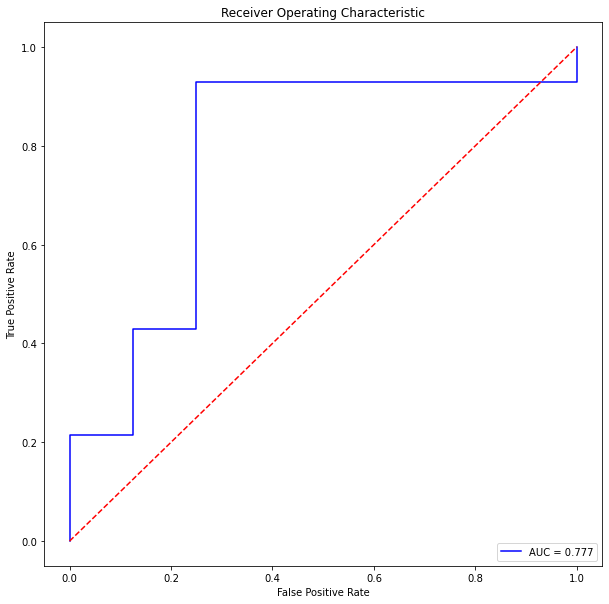

In [14]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(model_eval.sample_label,
                                         model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.show()

Next, let's plot the precision-recall curve:

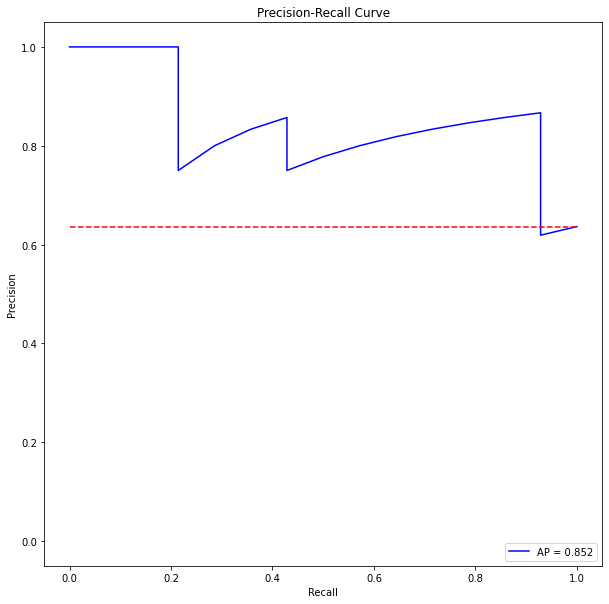

In [15]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
  model_eval.sample_label, model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
  model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label==1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall Curve")
plt.show()

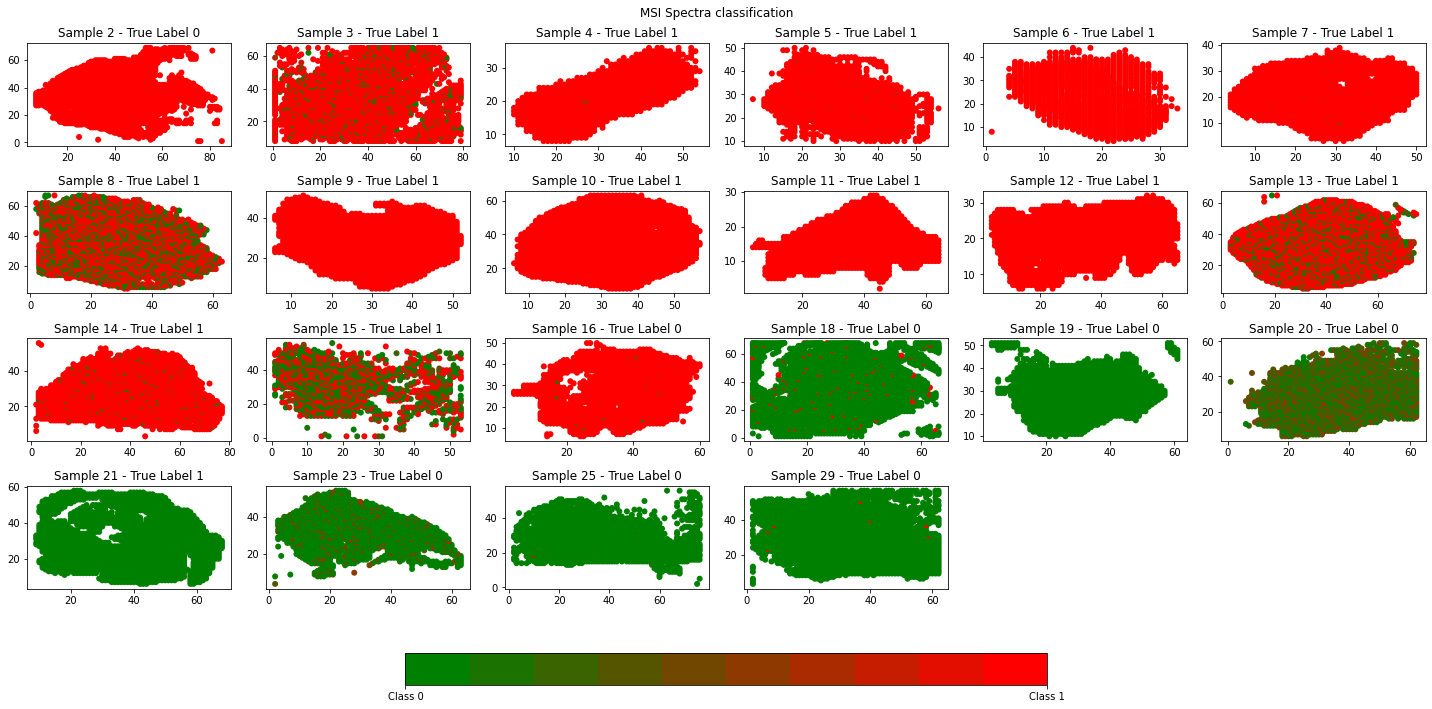

In [16]:
# Create custom binary color bar
colors = ["green", "red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(x_coordinates[(sample_numbers == key) & is_tissue],
                  y_coordinates[(sample_numbers == key) & is_tissue],
                  c=predictions[key],
                  cmap=cm,
                  edgecolor=['none'],
                  vmin=0,
                  vmax=1,
                  linewidths=0)
  #
  ax.set_title(f"Sample {key} - True Label {true_labels[key][0]}")
# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("MSI Spectra classification")

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(im,
                    ax=axes.ravel().tolist(),
                    location="bottom",
                    orientation="horizontal",
                    fraction=0.05,
                    pad=0.10)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"])

# Show plot
plt.show()

### ***Leave one sample out classification evaluation - non tissue spectra's:***

Next, let's get the prediction of each of left out sample non tissue spectra's:

In [17]:
# Define dict for saving predictions and true labels
predictions = {}
true_labels = {}

# Loop over each sample number
for exclude_sample in tqdm(np.unique(sample_numbers)):
  # Clear graph
  K.clear_session()
  gc.collect()
  
  # Create filter for training data
  test_filter = ((sample_numbers == exclude_sample) & ~is_tissue)

  # Get indexes of all data
  indexes = np.arange(len(sample_numbers))

  # Create test data generator
  test_generator = create_ds(indexes[test_filter], BATCH_SIZE)

  # Get saved model path
  model_path = os.path.join(MODELS_PATH, f"excluded_{exclude_sample}/")

  # Load model
  classification_model = tf.keras.models.load_model(model_path)

  # Get predictions
  predictions[exclude_sample] = classification_model.predict(x=test_generator)
  
  # Get corresponding true labels
  true_labels[exclude_sample] = labels[test_filter]

  # Clean model for next iteration
  classification_model = None

100%|██████████| 22/22 [02:16<00:00,  6.21s/it]


Next, let's get some statistics about each left out sample predictions:

In [18]:
# Set pandas display format
pd.options.display.float_format = '{:.10f}'.format
# Create datafrmae of each sample left out
model_eval = pd.DataFrame({"sample_left_out": predictions.keys()})
# Get the minimum prediction value of each sample left out
model_eval["min_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].min())
# Get the maximum prediction value of each sample left out
model_eval["max_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].max())
# Get the median prediction value of each sample left out
model_eval["median_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: np.median(predictions[key]))
# Get the mean prediction value of each sample left out
model_eval["mean_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].mean())
# Get the standard deviation prediction value of each sample left out
model_eval["std_spectra_prediction"] = model_eval.sample_left_out.apply(
    lambda key: predictions[key].std())
# Get the sample prediction = majority rule of sample spectra's prediction
model_eval["sample_label"] = model_eval.sample_left_out.apply(
    lambda key: true_labels[key][0])
# Get the sample true label
model_eval["sample_prediction"] = (model_eval.mean_spectra_prediction >
                                   0.5).astype(int)
# Print statistics
model_eval

,sample_left_out,min_spectra_prediction,max_spectra_prediction,median_spectra_prediction,mean_spectra_prediction,std_spectra_prediction,sample_label,sample_prediction
0,2,0.0000000024,1.0000000000,0.9999938011,0.9723519087,0.1533369720,0,1
1,3,0.0000033178,1.0000000000,0.9980413914,0.9091392159,0.2273983657,1,1
2,4,0.9999953508,1.0000000000,1.0000000000,1.0000000000,0.0000001926,1,1
3,5,0.6735029221,0.9795441031,0.9344048500,0.9261478186,0.0360417478,1,1
4,6,0.4966676831,0.9964690208,0.9465923309,0.9279042482,0.0633834451,1,1
5,7,0.0624675639,0.9998136163,0.9745995402,0.8785490990,0.1855943948,1,1
6,8,0.0000000000,1.0000000000,0.9999916553,0.9022569656,0.2712062001,1,1
7,9,0.9892784953,0.9999663830,0.9996995926,0.9992801547,0.0011672053,1,1
8,10,0.9966679215,0.9999924898,0.9999011755,0.9998131394,0.0002427620,1,1
9,11,0.6663514972,0.9993765950,0.9885318279,0.9815470576,0.0252567194,1,1


Next, let's evaluate the classification performance:

In [19]:
# Get accuracy
accuracy = metrics.accuracy_score(model_eval.sample_label,
                                  model_eval.sample_prediction)
# Get balanced accuracy
b_accuracy = metrics.balanced_accuracy_score(model_eval.sample_label,
                                             model_eval.sample_prediction)
# Get precision
precision = metrics.precision_score(model_eval.sample_label,
                                    model_eval.sample_prediction)
# Get recall
recall = metrics.recall_score(model_eval.sample_label,
                              model_eval.sample_prediction)
# Get  f1 score
f1 = metrics.f1_score(model_eval.sample_label, model_eval.sample_prediction)

# Print metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Balanced  Accuracy: {b_accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 score: {f1:.3f}")

Accuracy: 0.818
Balanced  Accuracy: 0.804
Precision: 0.857
Recall: 0.857
F1 score: 0.857


Next, let's plot the roc curve:

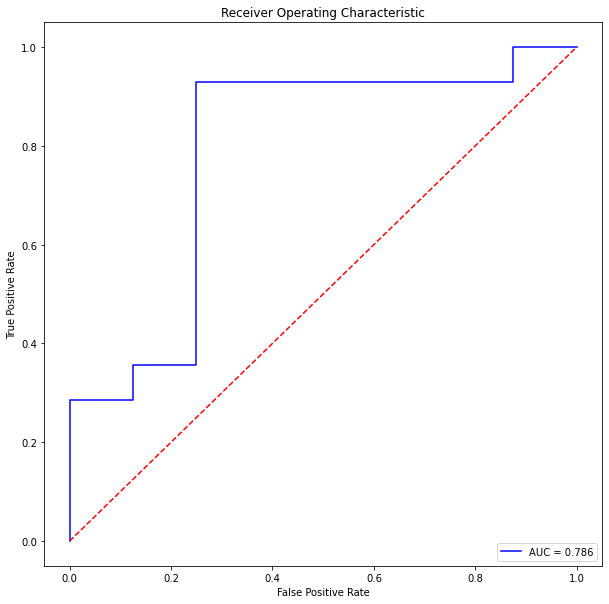

In [20]:
# Compute Receiver operating characteristic
fpr, tpr, thresholds = metrics.roc_curve(model_eval.sample_label,
                                         model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
roc_auc = metrics.auc(fpr, tpr)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, "b", label=f"AUC = {roc_auc:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.show()

Next, let's plot the precision-recall curve:

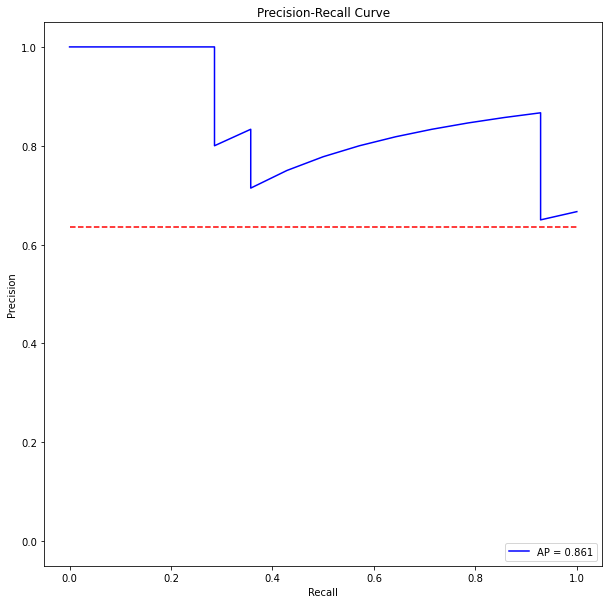

In [21]:
# Compute Receiver operating characteristic
precision, recall, thresholds = metrics.precision_recall_curve(
  model_eval.sample_label, model_eval.mean_spectra_prediction)
# Compute Area Under the Curve
pr_avg_precision = metrics.average_precision_score(
  model_eval.sample_label, model_eval.mean_spectra_prediction
)
# calculate the no skill line as the proportion of the positive class
no_skill = sum(model_eval.sample_label==1) / len(model_eval.sample_label)

# Plot ROC curve + AUC
plt.figure(figsize=(10, 10))
plt.plot(recall, precision, "b", label=f"AP = {pr_avg_precision:.3f}")
plt.legend(loc="lower right")
plt.plot([0, 1], [no_skill, no_skill], "r--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Precision-Recall Curve")
plt.show()

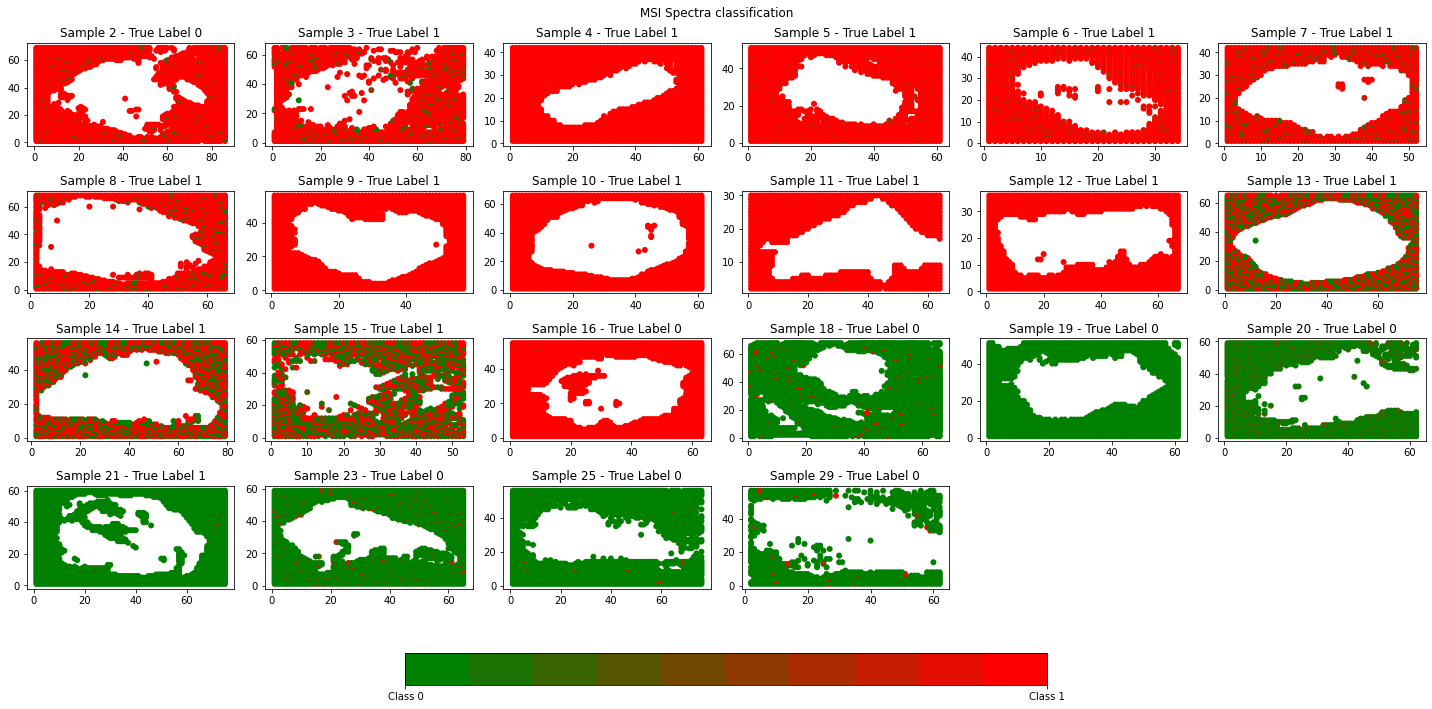

In [22]:
# Create custom binary color bar
colors = ["green", "red"]
cm = LinearSegmentedColormap.from_list("Class", colors, N=10)

# Create subplots
fig, axes = plt.subplots(4, 6, figsize=(20, 10))

# Get all samples
keys = predictions.keys()

# Loop over each sample and subplot
for key, ax in zip(keys, axes.flat[:len(keys)]):
  # Plot samples spectra's predictions
  im = ax.scatter(x_coordinates[(sample_numbers == key) & ~is_tissue],
                  y_coordinates[(sample_numbers == key) & ~is_tissue],
                  c=predictions[key],
                  cmap=cm,
                  edgecolor=['none'],
                  vmin=0,
                  vmax=1,
                  linewidths=0)
  #
  ax.set_title(f"Sample {key} - True Label {true_labels[key][0]}")
# Loop over non used subplots
for ax in axes.flat[len(keys):]:
  # Delete subplot
  fig.delaxes(ax)

# Add title
fig.suptitle("MSI Spectra classification")

# Sort plot layout
fig.tight_layout(h_pad=2, w_pad=1)

# Add one color bar
cbar = fig.colorbar(im,
                    ax=axes.ravel().tolist(),
                    location="bottom",
                    orientation="horizontal",
                    fraction=0.05,
                    pad=0.10)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Class 0", "Class 1"])

# Show plot
plt.show()

### ***MSI parsers closing:***

Next, let"s close MSI parsers:

In [23]:
# Closing parsers
for reader in parsers.values():
  if reader.m:
    reader.m.close()